In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
ac = np.loadtxt('A5_data/ac.txt')
s = np.loadtxt('A5_data/s.txt')
time = np.loadtxt('A5_data/time.txt')
fs = 1/(time[1]-time[0])

df = pd.DataFrame({'time':time, 's':s, 'ac':ac})

In [20]:
times = df['time'][df['time']<=20]
ss= df['s'][df['time']<=20]
acs= df['ac'][df['time']<=20]

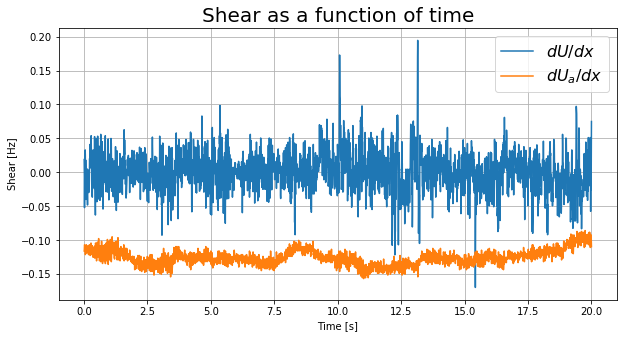

In [40]:
plt.figure(figsize=(10,5))
plt.plot(times, ss, label='$dU/dx$')
plt.plot(times, acs, label='$dU_a/dx$')
plt.legend(fontsize=16)
plt.xlabel('Time [s]')
plt.ylabel('Shear [Hz]')
plt.title('Shear as a function of time', fontsize=20)
plt.grid()

plt.show()

# Question 2

In [41]:
from scipy.signal import periodogram

In [55]:
ff_s1, Pdgrm_s1 = periodogram(s, fs=fs, nfft=64)
ff_s2, Pdgrm_s2 = periodogram(s, fs=fs, nfft=256)
ff_s3, Pdgrm_s3 = periodogram(s, fs=fs, nfft=2560)
ff_s4, Pdgrm_s4 = periodogram(s, fs=fs, nfft=24000)

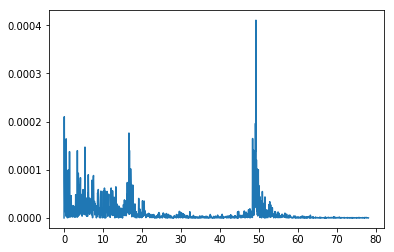

In [58]:
plt.plot(ff_s3, Pdgrm_s3)

In [59]:
len(s)

44434